In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns


## Графики частичной зависимости и индивидуальных условных ожиданий

Графики частичных зависимостей (PDP) показывают зависимость между целевой функцией и набором интересующих признаков, превосходящую значения всех других признаков (дополняющих признаков). Из-за пределов человеческого восприятия размер набора интересующих объектов должен быть небольшим (обычно один или два), поэтому они обычно выбираются из числа наиболее важных объектов.

Аналогично, график индивидуального условного математического ожидания (ICE) показывает зависимость между целевой функцией и интересующим нас признаком. Однако, в отличие от графиков частичной зависимости (PDP), которые показывают среднее влияние интересующих объектов, графики ICE отображают зависимость прогноза от объекта для каждой выборки отдельно, по одной линии на выборку. Для графиков ICE поддерживается только один интересующий объект.

In [63]:
bike =  pd.read_csv('dataset/bike.csv', index_col='Unnamed: 0')
display(bike.tail())
X = bike.drop(['count'],axis=1)
y = bike['count']

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61
17378,spring,1,12,23,False,1,True,clear,10.66,13.635,0.65,8.9981,49


Признак `погода` имеет особенность: категория `heavy_rain` является редкой категорией.

In [64]:
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

In [65]:
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)

Разделим данные по годам и создадим тренировочный и тестовый набор.

In [66]:
display(X["year"].value_counts())

year
1    8734
0    8645
Name: count, dtype: int64

In [67]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8645 entries, 0 to 8644
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8645 non-null   object  
 1   month       8645 non-null   int64   
 2   hour        8645 non-null   int64   
 3   holiday     8645 non-null   bool    
 4   weekday     8645 non-null   int64   
 5   workingday  8645 non-null   bool    
 6   weather     8645 non-null   category
 7   temp        8645 non-null   float64 
 8   feel_temp   8645 non-null   float64 
 9   humidity    8645 non-null   float64 
 10  windspeed   8645 non-null   float64 
dtypes: bool(2), category(1), float64(4), int64(3), object(1)
memory usage: 633.3+ KB


Соберем признаки

In [69]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

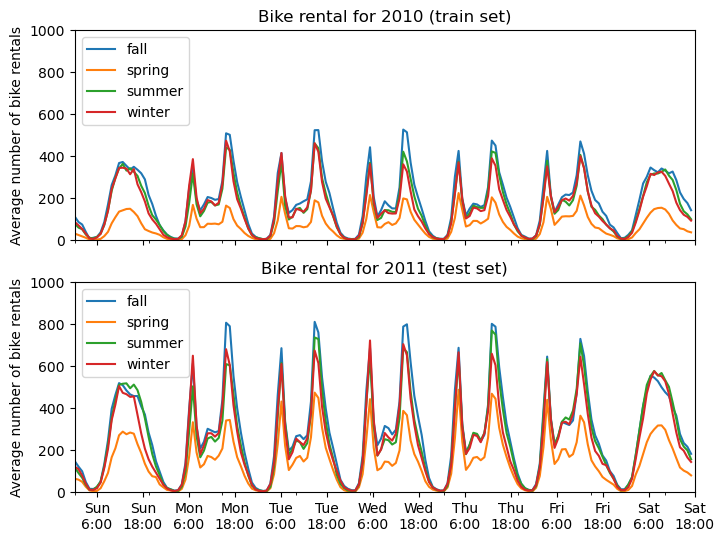

In [70]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bike.groupby(
    ["year", "season", "weekday", "hour"], observed=True
).mean(numeric_only=True)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season", observed=True).plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

Очевидны ряд отличий:
- различие между тренировочной и тестовой группой заключается в том, что в тестовой группе количество прокатов велосипедов выше. По этой причине неудивительно, что модель машинного обучения может занижает количество прокатов велосипедов.
- в весенний сезон количество пунктов проката велосипедов сокращается.
- в рабочие дни наблюдается определенная тенденция в период с 6-7 утра до 5-6 вечера, когда наблюдается пик проката велосипедов. Мы можем иметь в виду эти различные идеи и использовать их для понимания графика частичной зависимости.

In [71]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

In [72]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline

print("Training HistGradientBoostingRegressor...")
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
Test R2 score: 0.63


Здесь мы использовали гиперпараметры по умолчанию для модели повышения градиента без какой-либо предварительной обработки, поскольку древовидные модели по своей природе не требуют перемасштабирования данных.

Мы построим частичную зависимость для некоторых числовых и категориальных характеристик.

Computing partial dependence plots...


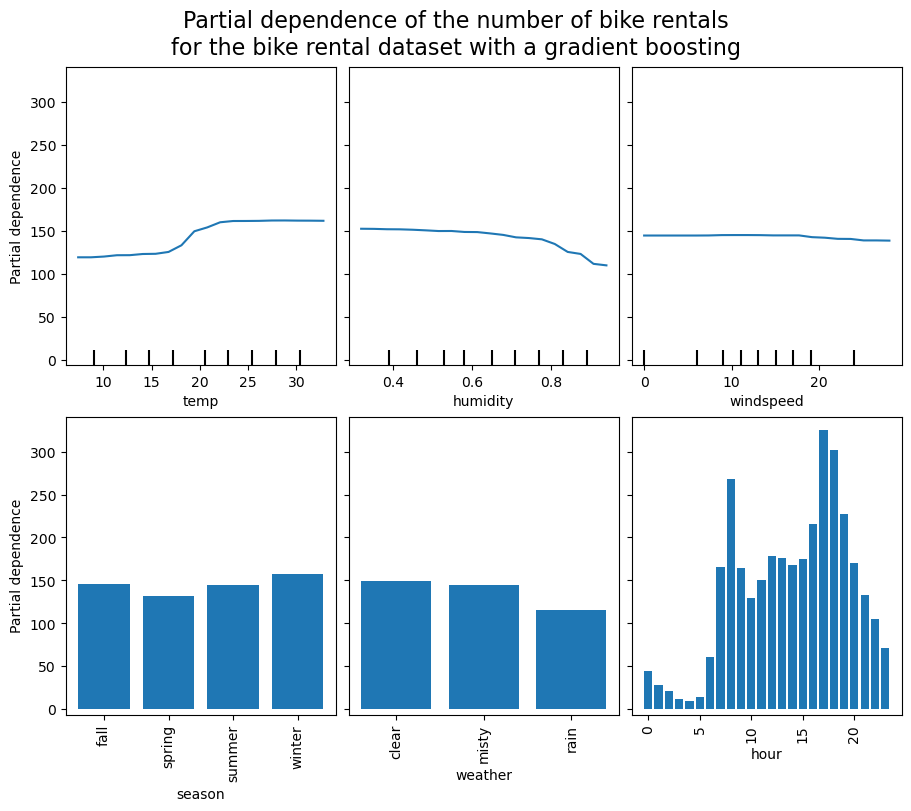

In [73]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


common_params = {
    "subsample": 50,
    "n_jobs": -1,
    "grid_resolution": 20,
    "random_state": 42,
}


features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}


print("Computing partial dependence plots...")
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with a gradient boosting"
    ),
    fontsize=16,
)

Давайте разберемся, что у нас на графиках  

Сначала мы рассмотрим числовые характеристики PDP.

Для обеих моделей общая тенденция изменения PDP температуры заключается в том, что количество пользователей проката велосипедов увеличивается с повышением температуры. Мы можем провести аналогичный анализ, но с противоположной тенденцией для характеристик влажности. Количество прокатов велосипедов уменьшается с повышением влажности. 

Также, мы видим ту же тенденцию в отношении функции скорости ветра. Количество прокатов велосипедов уменьшается при увеличении скорости ветра для обеих моделей. 

Теперь мы рассмотрим графики частичной зависимости для категориальных признаков.

Мы видим, что весенний сезон имеет самымый низким показатель для сезонного признака. Для признака погоды категория дождя является самым низким показателем. 

Что касается часового признака, то мы видим два пика в районе 7 утра и 6 вечера. Эти результаты согласуются с наблюдениями, которые мы сделали ранее над набором данных.


**Индивидуальные эффекты**

PDP - это среднее значение для минимальных эффектов функций. Мы усредняем реакцию всех образцов из предоставленного набора. Таким образом, некоторые эффекты могут быть скрыты. В связи с этим можно построить график для каждой отдельной реакции. Это представление называется графиком индивидуального эффекта (ICE). На графике ниже мы отображаем 50 случайно выбранных льдов для характеристик температуры и влажности.

Computing partial dependence plots and individual conditional expectation...


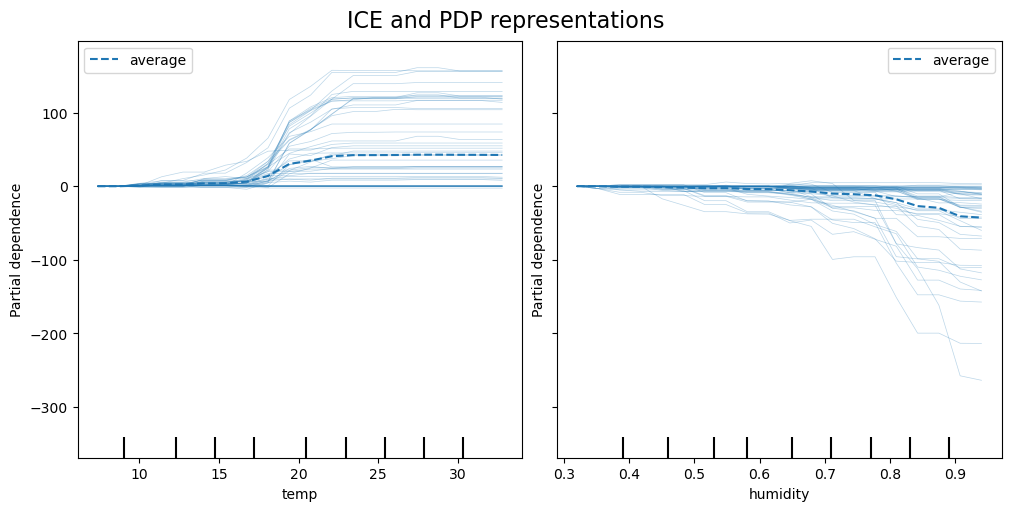

In [74]:
print("Computing partial dependence plots and individual conditional expectation...")

_, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp", "humidity"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

PDP с двумя интересующими нас характеристиками позволяют нам визуализировать взаимодействие между ними. Однако, ICE не может быть отображен на подобном графике и, следовательно, интерпретирован. 
Давайте посмотрим и интерпритуруем взаимодействие переменных

Computing partial dependence plots...


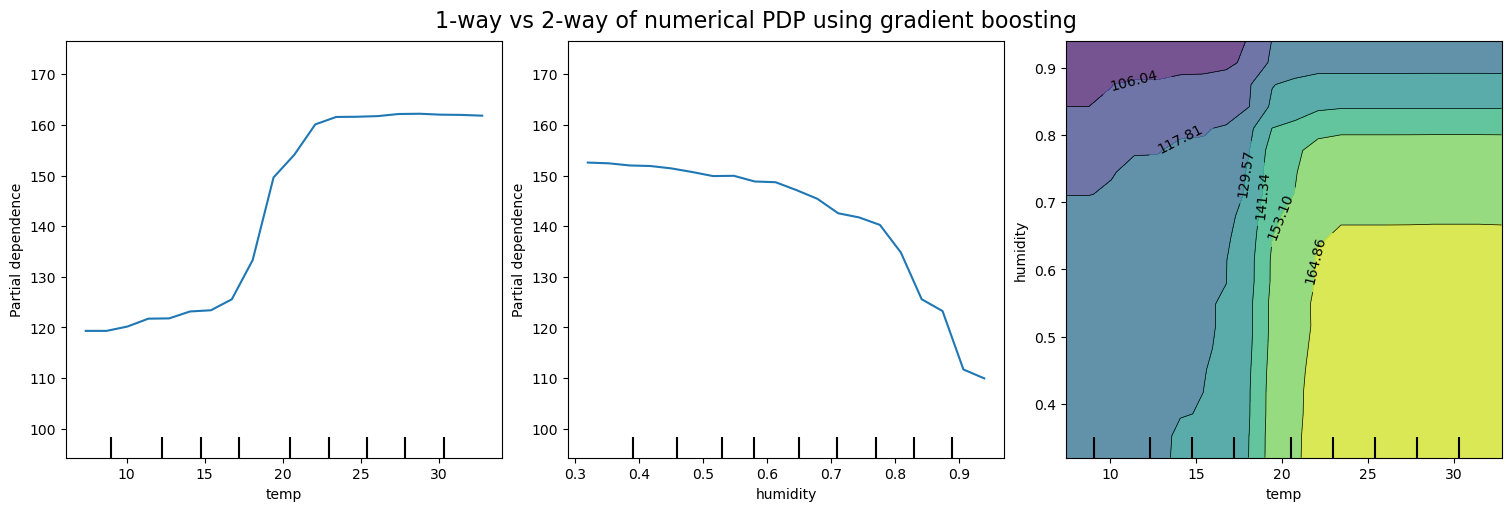

In [75]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

График двусторонней частичной зависимости показывает зависимость количества прокатов велосипедов от общих 
значений температуры и влажности. Мы хорошо видим взаимосвязь между этими двумя параметрами. При температуре выше 20 градусов по Цельсию влажность оказывает влияние на количество прокатов велосипедов, которое, по-видимому, не зависит от температуры.

С другой стороны, при температуре ниже 20 градусов по Цельсию и температура, и влажность взаимно влияют на количество прокатов велосипедов.

Кроме того, наклон линий, превышающий порог в 20 градусов по Цельсию, сильно зависит от уровня влажности: в сухих условиях линия вертикальна, и горизонтальна при более влажных условиях с влажностью выше 70%.

Теперь мы сравним эти результаты с теми же графиками, рассчитанными для модели, которая была вынуждена изучать функцию прогнозирования, не зависящую от таких нелинейных взаимодействий признаков.

Computing partial dependence plots...


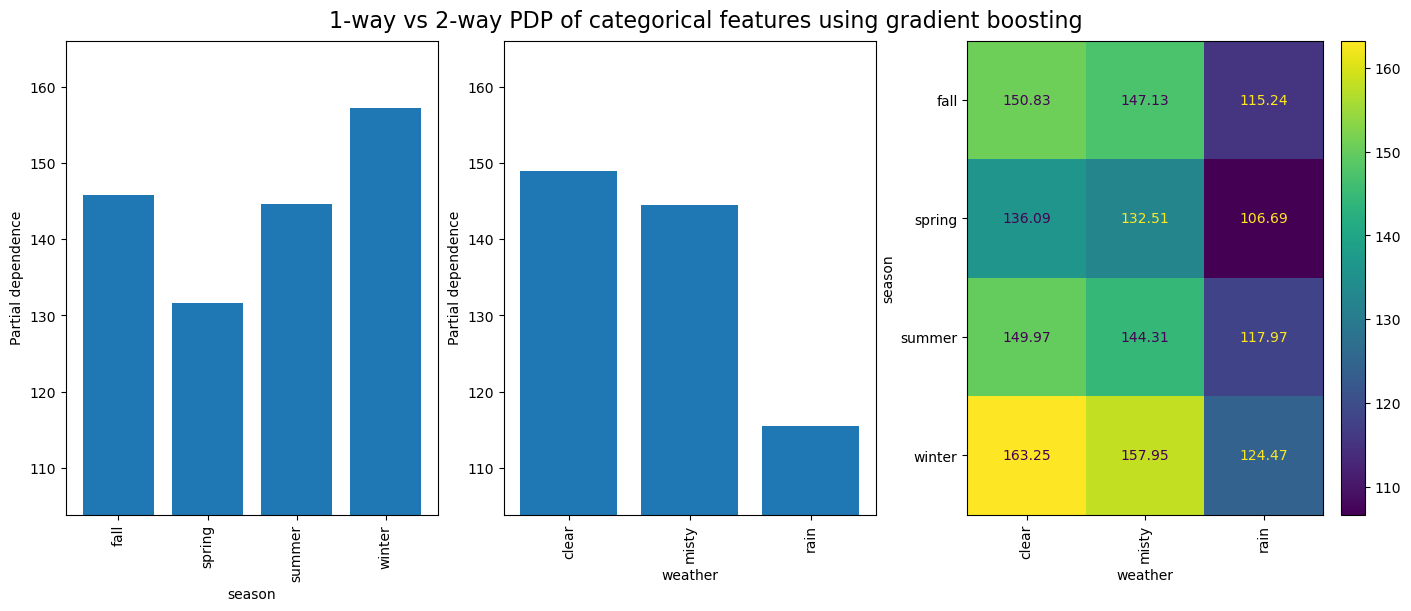

In [76]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["season", "weather", ("season", "weather")],
    "kind": "average",
    "categorical_features": categorical_features,
}
_, ax = plt.subplots(ncols=3, figsize=(14, 6), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)


_ = display.figure_.suptitle(
    "1-way vs 2-way PDP of categorical features using gradient boosting", fontsize=16
)